## Image网 Submission `128x128`

This contains a submission for the Image网 leaderboard in the `128x128` category.

In this notebook we:
1. Train on 1 pretext task: 
  - Train a network to do image inpatining on Image网's `/train`, `/unsup` and `/val` images. 
2. Train on 4 downstream tasks:
  - We load the pretext weights and train for `5` epochs.
  - We load the pretext weights and train for `20` epochs.
  - We load the pretext weights and train for `80` epochs.
  - We load the pretext weights and train for `200` epochs.
  
Our leaderboard submissions are the accuracies we get on each of the downstream tasks.

In [1]:
import json
import torch

import numpy as np

from functools import partial
from fastai2.basics import *
from fastai2.vision.all import *

In [2]:
torch.cuda.set_device(2)

In [3]:
# Chosen parameters
lr=2e-2
sqrmom=0.99
mom=0.95
beta=0.
eps=1e-6
bs=64 
sa=1

m = xresnet34
act_fn = Mish
pool = MaxPool

nc=20

In [4]:
source = untar_data(URLs.IMAGEWANG_160)
len(get_image_files(source/'unsup')), len(get_image_files(source/'train')), len(get_image_files(source/'val'))

(7750, 14669, 3929)

In [5]:
# Use the Ranger optimizer
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [6]:
m_part = partial(m, c_out=nc, act_cls=torch.nn.ReLU, sa=sa, pool=pool)
model_meta[m_part] = model_meta[xresnet18]

In [7]:
save_name = 'imagewang_contrast_simple_ep80'

## Pretext Task: Contrastive Learning

In [8]:
#export
from pytorch_metric_learning import losses
class XentLoss(losses.NTXentLoss):
    def forward(self, output1, output2):
        stacked = torch.cat((output1, output2), dim=0)
        labels = torch.arange(output1.shape[0]).repeat(2)
        return super().forward(stacked, labels, None)
    
class ContrastCallback(Callback):
    run_before=Recorder
    def __init__(self, size=256, aug_targ=None, aug_pos=None, temperature=0.1):
        self.aug_targ = ifnone(aug_targ, get_aug_pipe(size, min_scale=0.7))
        self.aug_pos = ifnone(aug_pos, get_aug_pipe(size, min_scale=0.4))
        self.temperature = temperature
        
    def update_size(self, size):
        pipe_update_size(self.aug_targ, size)
        pipe_update_size(self.aug_pos, size)
        
    def begin_fit(self): 
        self.old_lf = self.learn.loss_func
        self.old_met = self.learn.metrics
        self.learn.metrics = []
        self.learn.loss_func = losses.NTXentLoss(self.temperature)
        
    def after_fit(self):
        self.learn.loss_fun = self.old_lf
        self.learn.metrics = self.old_met
        
    def begin_batch(self):
        xb, = self.learn.xb
        xb_targ = self.aug_targ(xb)
        xb_pos = self.aug_pos(xb)
        self.learn.xb = torch.cat((xb_targ, xb_pos), dim=0),
        self.learn.yb = torch.arange(xb_targ.shape[0]).repeat(2),
        

In [9]:
#export
def pipe_update_size(pipe, size):
    for tf in pipe.fs:
        if isinstance(tf, RandomResizedCropGPU):
            tf.size = size

In [10]:
#export
def get_aug_pipe(size, min_scale=0.4, stats=imagenet_stats, erase=True, **kwargs):
    aug_tfms = aug_transforms(size=size, min_scale=min_scale, **kwargs)
    tfms = [Normalize.from_stats(*stats), *aug_tfms]
    if erase: tfms.append(RandomErasing(sh=0.1))
    pipe = Pipeline(tfms)
    pipe.split_idx = 0
    return pipe

In [11]:
def get_dbunch(size, bs, workers=8, dogs_only=False):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    folders = ['unsup', 'val'] if dogs_only else None
    files = get_image_files(source, folders=folders)
    
    tfms = [[PILImage.create, ToTensor, Resize(size)], 
            [lambda x: x.parent.name, Categorize()]]
    
#     dsets = Datasets(files, tfms=tfms, splits=GrandparentSplitter(train_name='unsup', valid_name='val')(files))
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
#     batch_tfms = [IntToFloatTensor, *aug_transforms(p_lighting=1.0, max_lighting=0.9)]
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    dls.path = source
    return dls

In [12]:
size = 128
bs = 256

dbunch = get_dbunch(160, bs)
# dbunch.c = nc
dbunch.c = 128

len(dbunch.train.dataset)

23714

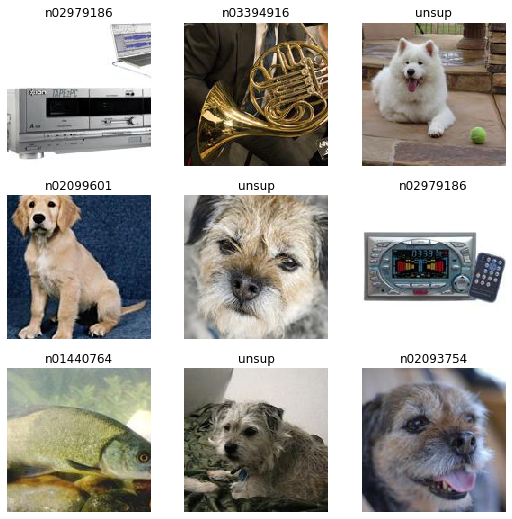

In [13]:
dbunch.show_batch()

In [14]:
# # xb = TensorImage(torch.randn(1, 3,128,128))
# afn_tfm, lght_tfm = aug_transforms(p_lighting=1.0, max_lighting=0.8, p_affine=1.0)
# # lght_tfm.split_idx = None
# xb.allclose(afn_tfm(xb)), xb.allclose(lght_tfm(xb, split_idx=0))

In [15]:
aug = get_aug_pipe(size, min_scale=0.3, mult=1, max_lighting=0.3)
aug2 = get_aug_pipe(size, min_scale=0.25, mult=2, max_lighting=0.2)
cbs = ContrastCallback(size=size, aug_targ=aug, aug_pos=aug2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


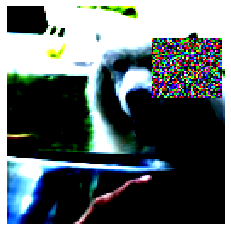

In [16]:
xb,yb = dbunch.one_batch()
nrm = Normalize.from_stats(*imagenet_stats)
show_image(nrm.decodes(aug(xb)[0]))

In [17]:
ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 512), nn.ReLU(), nn.Linear(512, 128))
learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                    metrics=[], loss_func=CrossEntropyLossFlat(), cbs=cbs, pretrained=False,
                    config={'custom_head':ch}
                   )

In [18]:

# state_dict = torch.load(f'{save_name}.pth')
# learn.model[0].load_state_dict(state_dict, strict=False)

In [19]:
learn.unfreeze()
learn.fit_flat_cos(80, 4e-2, wd=1e-2)

epoch,train_loss,valid_loss,time
0,2.075817,2.402596,00:49
1,1.314942,1.616942,00:48
2,0.963349,0.902339,00:48
3,0.912967,0.813528,00:48
4,0.761244,1.300707,00:48
5,0.691958,0.677284,00:48
6,0.691219,0.691370,00:48
7,0.622910,0.838976,00:48
8,0.528768,0.451072,00:48
9,0.564089,0.640043,00:48


In [20]:
torch.save(learn.model[0].state_dict(), f'{save_name}.pth')

In [21]:
# learn.save(save_name)

## Downstream Task: Image Classification

In [19]:
def get_dbunch(size, bs, workers=8, dogs_only=False):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    if dogs_only:
        dog_categories = [f.name for f in (source/'val').ls()]
        dog_train = get_image_files(source/'train', folders=dog_categories)
        valid = get_image_files(source/'val')
        files = dog_train + valid
        splits = [range(len(dog_train)), range(len(dog_train), len(dog_train)+len(valid))]
    else:
        files = get_image_files(source)
        splits = GrandparentSplitter(valid_name='val')(files)
        
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [lambda x: x.parent.name, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=splits)
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    dls.path = source
    return dls

In [20]:
# opt_func = SGD
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [22]:
def do_train(size=128, bs=64, lr=1e-2, epochs=5, runs=5, dogs_only=False, save_name=None):
    dbunch = get_dbunch(size, bs, dogs_only=dogs_only)
    for run in range(runs):
        print(f'Run: {run}')
        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func, normalize=False,
                metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
                pretrained=False,
                config={'custom_head':ch})

        if save_name is not None:
            state_dict = torch.load(f'{save_name}.pth')
            learn.model[0].load_state_dict(state_dict)
        return learn
        learn.unfreeze()
        learn.fit_one_cycle(epochs, lr, wd=1e-2)

In [24]:
l = do_train(epochs=epochs, runs=runs, lr=2e-2, dogs_only=False, save_name=save_name)

Run: 0


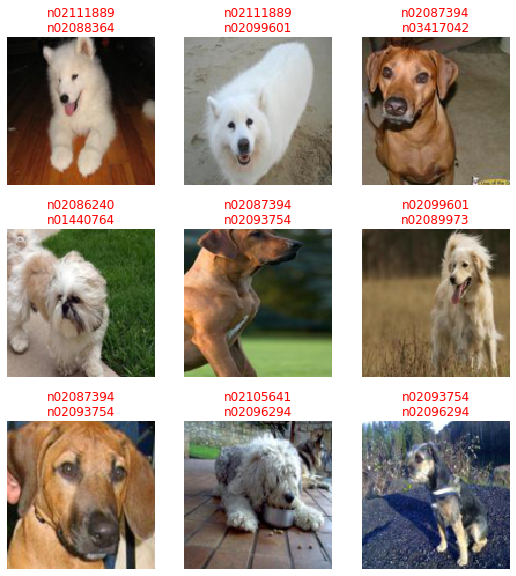

In [25]:
l.show_results()

### 5 Epochs

In [23]:
epochs = 5
runs = 5

In [ ]:
do_train(epochs=epochs, runs=runs, lr=2e-2, dogs_only=False, save_name=save_name)

## Random weights - ACC = 0.337999	

In [ ]:
do_train(epochs=epochs, runs=1, dogs_only=False, save_name=None)

### 20 Epochs

In [27]:
epochs = 10
runs = 1

In [31]:
do_train(epochs=20, runs=runs, lr=1e-2, dogs_only=False, save_name=save_name)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.984228,3.811894,0.005345,0.160346,00:20
1,1.152920,2.530662,0.263680,0.701196,00:20
2,0.875422,2.451254,0.326037,0.756936,00:20
3,0.806118,2.523559,0.339781,0.758463,00:20
4,0.712171,2.290639,0.360906,0.797658,00:20
5,0.589699,2.104742,0.402902,0.830746,00:20
6,0.528968,2.139715,0.419445,0.832782,00:21
7,0.446696,2.247438,0.412319,0.814711,00:19
8,0.394226,2.275047,0.403156,0.808094,00:19
9,0.316629,2.525203,0.443370,0.847798,00:20


In [30]:
do_train(epochs=20, runs=runs, lr=1e-2, dogs_only=False, save_name=None)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.684759,3.798333,0.009672,0.277424,00:20
1,1.344519,3.802003,0.059303,0.420209,00:20
2,1.252760,3.163347,0.117333,0.519980,00:21
3,1.124767,3.720282,0.022398,0.362179,00:21
4,0.989669,3.496054,0.111479,0.507254,00:19
5,0.890085,3.302375,0.106643,0.566047,00:20
6,0.780724,3.273095,0.167727,0.655892,00:19
7,0.704060,2.638619,0.258335,0.739628,00:21
8,0.655647,2.721385,0.252991,0.656656,00:20
9,0.591482,2.103746,0.352762,0.817002,00:19


In [28]:
do_train(epochs=epochs, runs=runs, lr=1e-2, dogs_only=False, save_name=save_name)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.650769,3.192566,0.099007,0.497837,00:23
1,1.004520,2.408788,0.329346,0.748282,00:23
2,0.805805,2.614886,0.306694,0.726393,00:22
3,0.675071,2.410335,0.328582,0.768389,00:22
4,0.559754,2.530421,0.376432,0.821838,00:22
5,0.455554,1.926492,0.471367,0.858743,00:21
6,0.373483,1.972312,0.469076,0.858997,00:22
7,0.304647,2.055345,0.465258,0.851871,00:22
8,0.259020,2.095863,0.464495,0.853907,00:22
9,0.236667,2.052885,0.473403,0.858488,00:22


In [29]:
do_train(epochs=10, runs=runs, lr=1e-2, dogs_only=False, save_name=None)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.623406,3.807921,0.027488,0.331128,00:22
1,1.385101,3.604283,0.060066,0.470094,00:22
2,1.159668,3.990276,0.045813,0.444133,00:22
3,0.960699,4.972397,0.048358,0.325274,00:22
4,0.823018,2.203171,0.294477,0.790023,00:22
5,0.700964,2.357208,0.292186,0.755918,00:22
6,0.593768,2.082908,0.370323,0.824128,00:22
7,0.522269,1.931200,0.421227,0.843726,00:22
8,0.438223,1.948299,0.427590,0.850089,00:21
9,0.406216,1.935278,0.434971,0.851616,00:23


In [25]:
do_train(epochs=10, runs=runs, lr=1e-2, dogs_only=True, save_name=save_name)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.318611,3.241659,0.054212,0.282769,00:04
1,3.022678,2.515970,0.152456,0.596589,00:05
2,2.629213,2.018284,0.290659,0.789768,00:05
3,2.261595,1.796848,0.368033,0.858234,00:05
4,1.979374,1.704620,0.403156,0.873250,00:04
5,1.732681,1.577596,0.447697,0.898702,00:04
6,1.529460,1.570090,0.469076,0.908374,00:04
7,1.343796,1.546575,0.464749,0.908883,00:04
8,1.184998,1.579431,0.476203,0.907356,00:04
9,1.035995,1.645412,0.491474,0.908628,00:05


In [24]:
do_train(epochs=epochs, runs=1, lr=1e-2, dogs_only=True, save_name=None)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.168406,2.914897,0.114787,0.429117,00:04
1,2.739160,2.255309,0.206668,0.728939,00:04
2,2.416611,2.668173,0.167727,0.730466,00:04
3,2.256499,3.263576,0.175872,0.631967,00:04
4,2.166459,3.906845,0.182998,0.688979,00:04
5,2.095417,2.026536,0.291932,0.802494,00:05
6,2.019794,2.159291,0.260626,0.777297,00:04
7,1.939466,2.270367,0.281497,0.770680,00:04
8,1.840208,2.189636,0.306185,0.788241,00:04
9,1.766716,2.963074,0.241792,0.765589,00:04


## 80 epochs

In [ ]:
epochs = 80
runs = 1

In [ ]:
do_train(epochs=epochs, runs=runs, dogs_only=False, save_name=save_name)

In [ ]:
do_train(epochs=epochs, runs=runs, dogs_only=False, save_name=None)

Accuracy: **62.18%**

### 200 epochs

In [ ]:
epochs = 200
runs = 1

In [ ]:
do_train(epochs=epochs, runs=runs, dogs_only=False, save_name=save_name)

Accuracy: **62.03%**